# It's Raining Cats and Dogs
   
##  Lab Assignment Three: Exploring Image Data 
   
### Justin Ledford, Luke Wood, Traian Pop

## Business Understanding

(10 points total).  
[10 points] Give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). Why is this data important and how will you know if you have gathered useful knowledge from the dataset? Be specific and use your own words to describe the aspects of the data.

## Data Preparation 
(20 points total)

[5 points] Read in your images data as numpy arrays. Resize and recolor images as necessary. 
[10 points] Linearize the images to create a table of 1-D image features (each row should be one image).   
[5 points] Visualize several images.


In [13]:
import numpy as np
from PIL import Image
import pandas as pd
import os
import glob

X = []
labels = []

# Image sizes
h, w = 150, 150 

for img_file in glob.iglob('data/*.jpg'):
    # Read in img as greyscale
    with Image.open(img_file).convert("L") as img:
        
        # Keep labels for each image in separate array
        if 'cat' in img_file:
            labels.append(0)
        else:
            labels.append(1)
        
        # Concatenate RGB into one row and collect
        X.append(np.concatenate(np.array(img)))
        
X = np.array(X)
labels = np.array(labels)

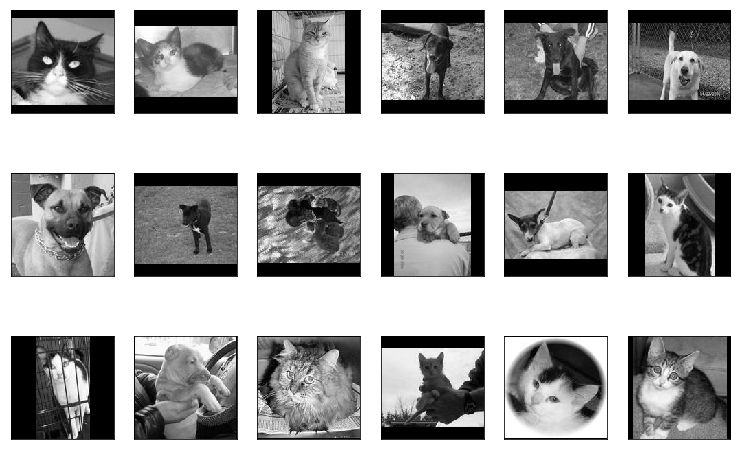

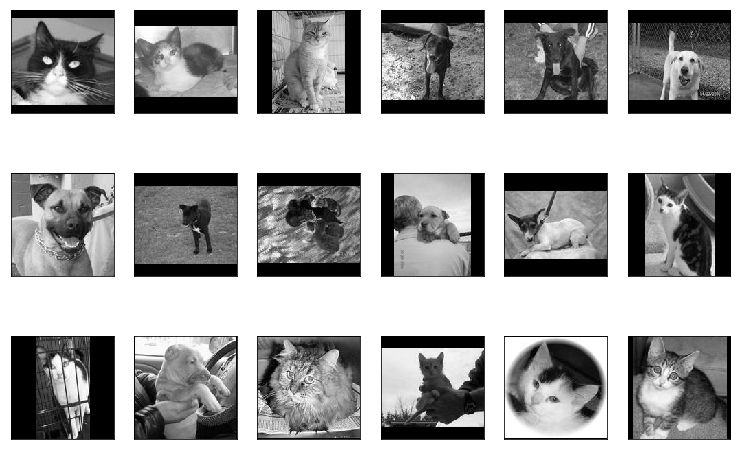

In [15]:
import matplotlib.pyplot as plt

# a helper plotting function (modified Larson's code)
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        #plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X, h, w) # defaults to showing a 3 by 6 subset of the faces

# Visualize some images
plt.show()

## Data Reduction 
(60 points total)

[10 points] Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. How many dimensions are required to adequately represent your image data?
[10 points] Perform non-linear dimensionality reduction of your image data. Compare the representation using non-linear dimensions to using linear dimensions. Do you prefer one method over another? Why?
[20 points] Perform feature extraction upon the images using any feature extraction technique (e.g., gabor filters, ordered gradients, etc.).
[20 points] Visualize the differences between instances in each target class. For example, a heat map of the pairwise differences among all instances is likely appropriate for you data. Do you think the features extracted are appropriate for classification on your dataset? 
